***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19
SUB_NBR = "08"

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import yaml

import category_encoders as ce
import lightgbm as lgb
from tqdm import tqdm
from tsforest.forecast import LightGBMForecaster
import optuna

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
if ASSESS:
    scales = pd.read_csv(f"{input_path}/scales.csv")
    skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv")

    dataset = (
        pd.read_parquet(f"{input_path}/train.parquet")
        .query("sku in @skus_for_assess.sku")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    dataset

In [7]:
with open(f"../config/dist_hparams.yml", "r") as file:
    dist_config = yaml.load(file, Loader=yaml.FullLoader)
    file.close()

dist_config

{'beta': 0.5607622708084541,
 'corr_factor': 1.2025296178014329,
 'lambda1': 0.5476473565886333,
 'lambda2': 0.8678989339789255}

In [8]:
with open(f"../data/skus_assess_m2.yaml", "r") as file:
    skus_assess_m2 = yaml.load(file, Loader=yaml.FullLoader)
    file.close()

***
## model config

In [14]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": "default",
    "listing_type": "default",
    "shipping_logistic_type": "default",
    "shipping_payment": "default",
    "item_domain_id": "default",
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id":"default",
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective':'tweedie',
    'tweedie_variance_power':1.6,
    'metric':'None',
    'num_iterations':1000,
    'max_bin': 63,
    'bin_construct_sample_cnt':20000000,
    'num_leaves': 2**8-1,
    'min_data_in_leaf': 2**8-1,
    'learning_rate': 0.02,
    'max_delta_step':1.,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'max_cat_threshold': 64,
    'cat_l2': 50,
    'cat_smooth': 50,
    'boost_from_average': False,
    'force_row_wise': True,
    'deterministic':True,
    'seed':SEED,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,5,7,]),
        "std":    (None, [1,], [3,5,7]),
    },
}

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 114.91 Mb (51.7% reduction)
Mem. usage decreased to 120.20 Mb (51.7% reduction)
Elapsed time for processing features: 0.5634237011273702 min.
[LightGBM] [Info] Total Bins 2520
[LightGBM] [Info] Number of data points in the train set: 1242194, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.814114
[100]	valid_0's rmsse: 0.76945
[150]	valid_0's rmsse: 0.764645
Early stopping, best iteration is:
[159]	valid_0's rmsse: 0.764584


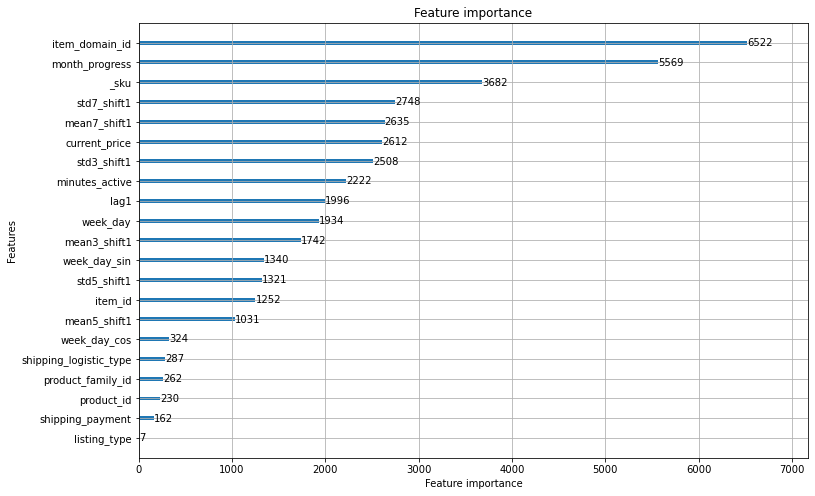

Elapsed time for training the model: 1.3427668849627177 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 672.64 Mb (51.7% reduction)
Mem. usage decreased to 700.67 Mb (51.7% reduction)
Elapsed time for processing features: 6.039610683917999 min.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 7271333, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.857922
[100]	valid_0's rmsse: 0.807616
[150]	valid_0's rmsse: 0.800691
[200]	valid_0's rmsse: 0.800595
Early stopping, best iteration is:
[184]	valid_0's rmsse: 0.800378


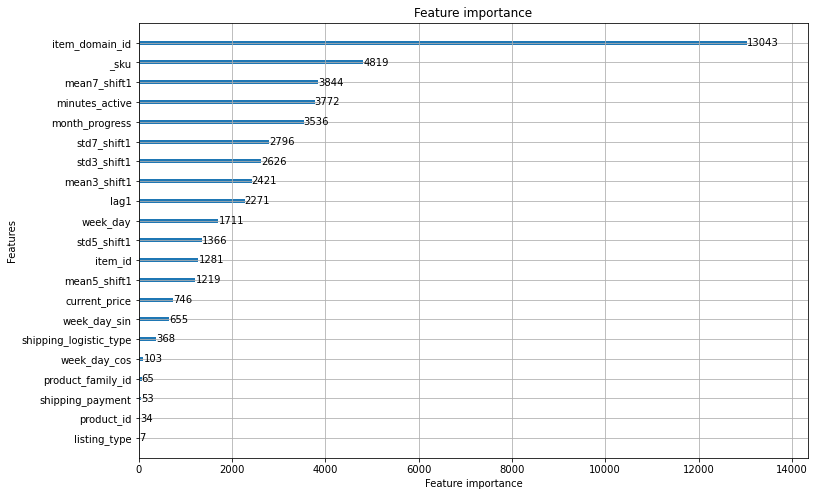

Elapsed time for training the model: 6.852417536576589 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 533.03 Mb (51.7% reduction)
Mem. usage decreased to 557.84 Mb (51.7% reduction)
Elapsed time for processing features: 3.9221306800842286 min.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 5762054, number of used features: 21
Training until validation scores don't improve for 30 rounds
[50]	valid_0's rmsse: 0.812797
[100]	valid_0's rmsse: 0.762317
[150]	valid_0's rmsse: 0.755524
[200]	valid_0's rmsse: 0.755375
Early stopping, best iteration is:
[185]	valid_0's rmsse: 0.755062


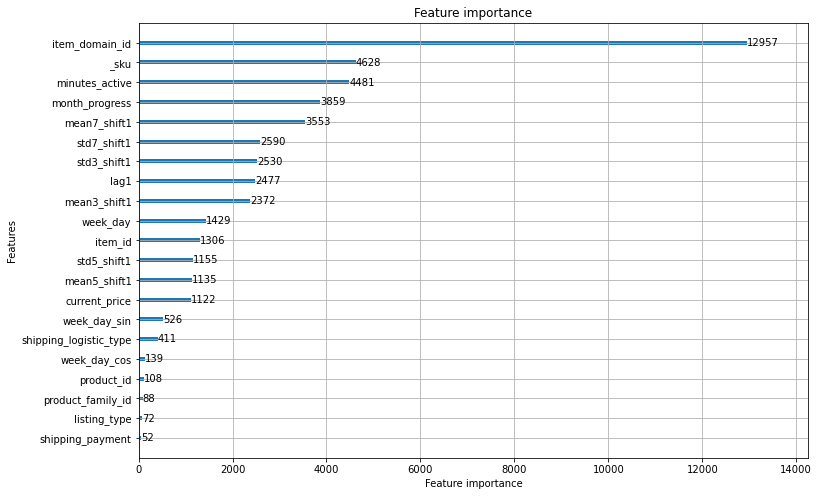

Elapsed time for training the model: 3.2631380478541057 min.


{'rmsse_MLA': 0.7645841229331601,
 'rmsse_MLB': 0.800378174988867,
 'rmsse_MLM': 0.7550616980344879,
 'rmsse_AVG': 0.773341331985505}

In [15]:
if ASSESS:
    models_by_site = list()
    sites = ["MLA","MLB","MLM"]

    for site in sites:
        print("-"*90)
        print(f"Preparing model for site: {site}")

        tic = time.time()
        train_data = dataset.query("site_id == @site").reset_index(drop=True)
        valid_idx = train_data.query("ds > '2021-03-01'").index

        model = LightGBMForecaster(**model_kwargs)
        model.prepare_features(train_data, valid_idx)
        model.train_features = reduce_mem_usage(model.train_features, verbose=True)
        model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
        gc.collect()
        tac = time.time()
        print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

        tic = time.time()
        evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
        model.fit(fit_kwargs={"verbose_eval":50, "feval":evaluator.evaluate})
        lgb.plot_importance(model.model.model, figsize=(12,8))
        plt.show()
        models_by_site.append(model)
        tac = time.time()
        print(f"Elapsed time for training the model: {(tac-tic)/60} min.")

    errors = list()
    sites = ["MLA","MLB","MLM"]
    for site,model in zip(sites,models_by_site):
        error = model.model.model.best_score["valid_0"]["rmsse"]
        errors.append(error)
    result = {
        "rmsse_MLA":errors[0], 
        "rmsse_MLB":errors[1],
        "rmsse_MLM":errors[2],
        "rmsse_AVG":np.mean(errors),
    }
    display(result)

In [16]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
        all_preds.append(preds)
    train_preds = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 9min 52s, sys: 22.8 s, total: 10min 15s
Wall time: 1min 53s


In [17]:
if ASSESS:
    train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
    train_errors = np.sqrt(train_preds.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    train_errors = pd.merge(train_errors, scales, how="inner", on="sku")
    train_errors["rmsse"] = train_errors.eval("rmse/scale")
    display(train_errors.groupby("site_id")["rmsse"].mean())
    train_errors = train_errors.set_index("sku")

site_id
MLA    0.669835
MLB    0.683405
MLM    0.710031
Name: rmsse, dtype: float64

In [18]:
%%time
if ASSESS:
    all_preds = list()
    for site,model in zip(sites,models_by_site):
        print("Preds for site:", site)
        preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
        all_preds.append(preds)
    oof = pd.concat(all_preds, axis=0, ignore_index=True)

Preds for site: MLA
Preds for site: MLB
Preds for site: MLM
CPU times: user 16min 54s, sys: 55.4 s, total: 17min 49s
Wall time: 30min 58s


In [19]:
if ASSESS:
    mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
    mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
    valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
    valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
    valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
    display(valid_errors.groupby("site_id")["rmsse"].mean())

site_id
MLA    0.771580
MLB    0.815389
MLM    0.771044
Name: rmsse, dtype: float64

In [20]:
if ASSESS:
    train_errors.to_csv(f"{results_path}/train_errors_lgbm-m1.csv", index=False)
    oof.to_csv(f"{results_path}/oof_preds_lgbm-m1.csv", index=False)

***
## Assessment of invetory days prediction

In [9]:
if ASSESS:
    if "oof" not in locals():
        oof = pd.read_csv("../results/oof_preds_lgbm-m1.csv")
    if "train_errors" not in locals():
        train_errors = pd.read_csv("../results/train_errors_lgbm-m1.csv")
        
    predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"), train_errors)
    predictor.fit(oof)

100%|██████████| 496797/496797 [01:01<00:00, 8134.67it/s]


In [10]:
if ASSESS:
    valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

    preds = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
        
    valid["days_to_stockout"] = np.asarray(preds)

100%|██████████| 496797/496797 [01:02<00:00, 7897.91it/s]


RMSE (mean):  10.37095537231485
MAE (mean):  7.737363459061927
MAE (median):  5.731869492012329


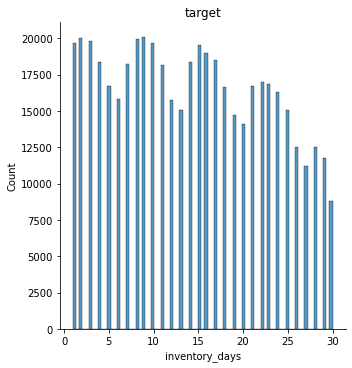

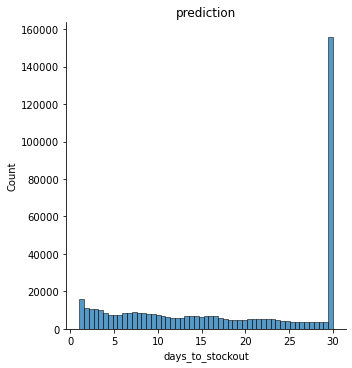

In [11]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.eval("abs(days_to_stockout - inventory_days)").median() )

    sns.displot(valid.inventory_days)
    plt.title("target")
    plt.show()

    sns.displot(valid.days_to_stockout)
    plt.title("prediction")
    plt.show()

RMSE (mean):  9.15487622664278
MAE (mean):  6.751869305533989
MAE (median):  4.973280247073978


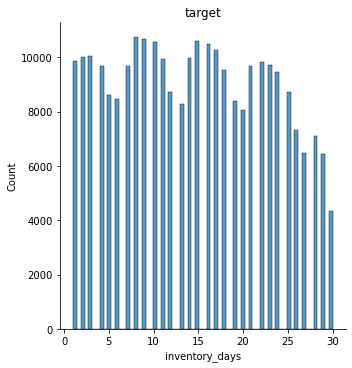

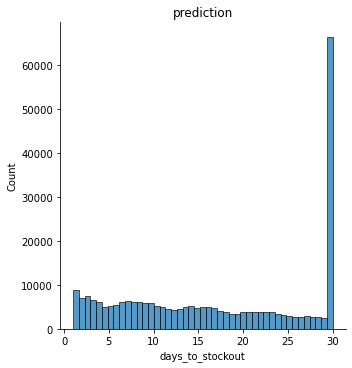

In [12]:
if ASSESS:
    print("RMSE (mean): ", np.sqrt(valid.query("sku in @skus_assess_m2").eval("(days_to_stockout - inventory_days)**2").mean()) )
    print("MAE (mean): ",  valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").mean() )
    print("MAE (median): ", valid.query("sku in @skus_assess_m2").eval("abs(days_to_stockout - inventory_days)").median() )

    sns.displot(valid.query("sku in @skus_assess_m2").inventory_days)
    plt.title("target")
    plt.show()

    sns.displot(valid.query("sku in @skus_assess_m2").days_to_stockout)
    plt.title("prediction")
    plt.show()

***
## Assessment of RPS

In [28]:
dist_config

{'beta': 0.5607622708084541,
 'corr_factor': 1.2025296178014329,
 'lambda1': 0.5476473565886333,
 'lambda2': 0.8678989339789255}

In [29]:
if ASSESS:
    valid_files = [fn for fn in glob(f"{input_path}/validation_seed*.csv") if "seed2.csv" not in fn]
    results = list()

    for files in valid_files:
        valid = pd.read_csv(files)

        preds_proba = list()
        for sku,df in tqdm(valid.groupby("sku")):
            preds_proba.append(predictor.predict_proba(
                sku, 
                stock=df.target_stock.values[0],
                dist_kwargs={"beta":dist_config["beta"]},
                lambda1=dist_config["lambda1"], 
                lambda2=dist_config["lambda2"],
            ))
        preds_proba = np.array(preds_proba)

        rps = scoring_function(valid.inventory_days.values, preds_proba)
        results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
        print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

100%|██████████| 496797/496797 [02:57<00:00, 2797.75it/s]


{'file': 'validation_seed19', 'rps': 3.8824043234099053}


100%|██████████| 496797/496797 [03:25<00:00, 2422.78it/s]


{'file': 'validation_seed23', 'rps': 3.8849802519156724}


100%|██████████| 496797/496797 [03:19<00:00, 2494.35it/s]


{'file': 'validation_seed17', 'rps': 3.887287633063588}


In [30]:
if ASSESS:
    display(pd.DataFrame(results))
    
    # cleanup ram
    del models_by_site
    gc.collect()

,file,rps
0,validation_seed19,3.882404
1,validation_seed23,3.884980
2,validation_seed17,3.887288


***
## model training

In [31]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 36.594396
nskus: 635633


In [32]:
test = (
    pd.read_parquet(f"{input_path}/test.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 292.71 Mb (51.7% reduction)
Elapsed time for processing features: 1.6991612672805787 min.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 3164181, number of used features: 21


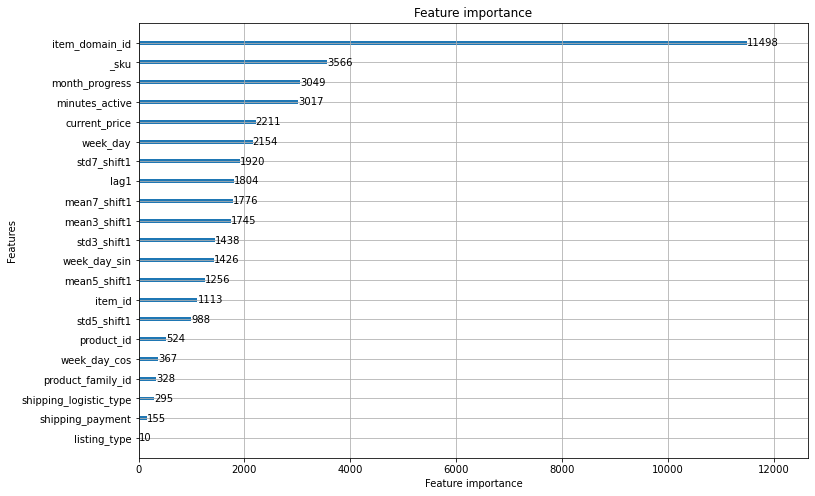

Elapsed time for training the model: 1.0212454517682394 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1764.36 Mb (50.7% reduction)
Elapsed time for processing features: 10.030090586344402 min.
[LightGBM] [Info] Total Bins 3163
[LightGBM] [Info] Number of data points in the train set: 18687512, number of used features: 21


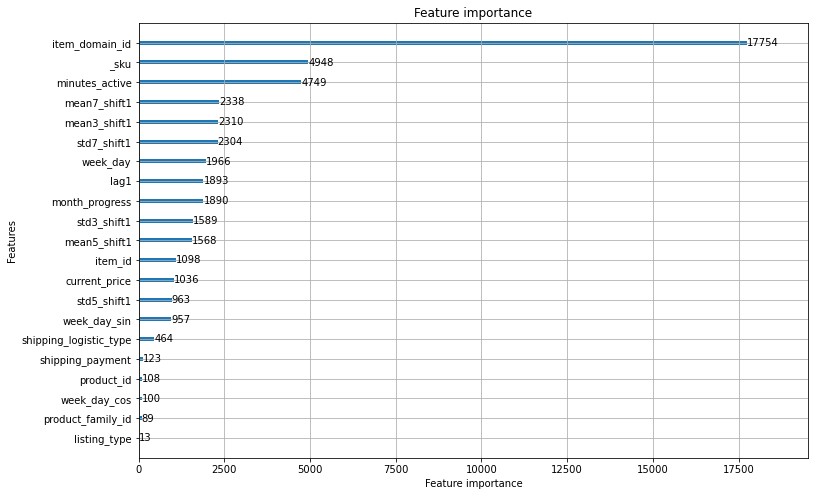

Elapsed time for training the model: 5.719226602713267 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1363.79 Mb (51.7% reduction)
Elapsed time for processing features: 7.080677771568299 min.
[LightGBM] [Info] Total Bins 3044
[LightGBM] [Info] Number of data points in the train set: 14742703, number of used features: 21


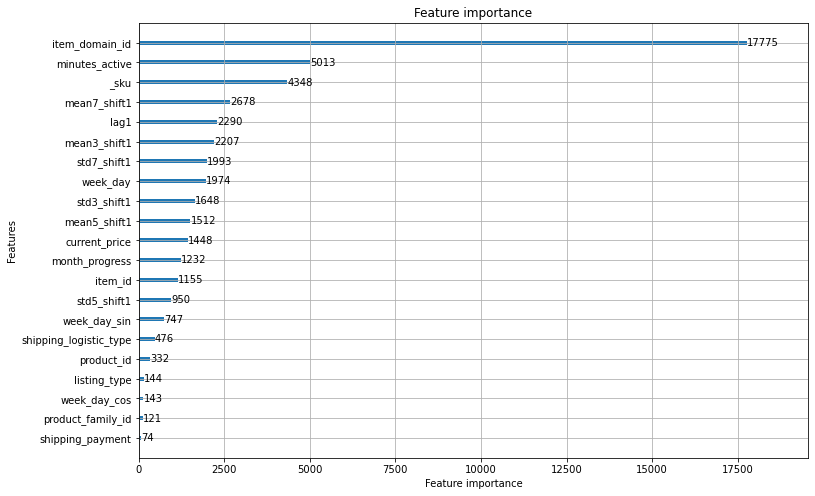

Elapsed time for training the model: 3.8144581357638043 min.


In [33]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 160,
    "MLB": 190,
    "MLM": 190,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = LightGBMForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    lgb.plot_importance(model.model.model, figsize=(12,8))
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [34]:
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)

3it [1:05:02, 1300.93s/it]


In [35]:
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}.csv", index=False)

predictions["y_pred"] = dist_config["corr_factor"] * predictions["y_pred"]
predictions.to_csv(f"../results/preds_m1_lgbm_sub{SUB_NBR}-corr.csv", index=False)

In [36]:
# todo: fix train_errors
predictor = InventoryDaysPredictor(dataset, train_errors)
predictor.fit(predictions)

100%|██████████| 526189/526189 [01:42<00:00, 5128.59it/s]


100%|██████████| 526189/526189 [01:37<00:00, 5422.29it/s]


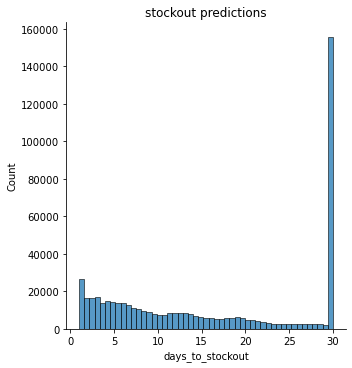

In [37]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

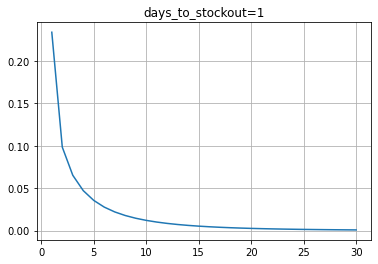

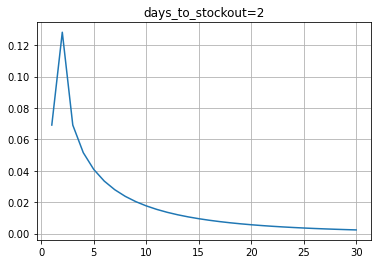

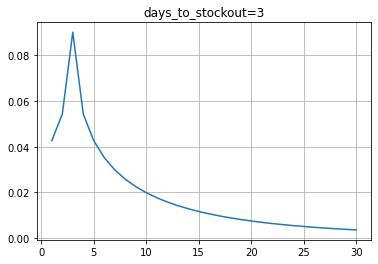

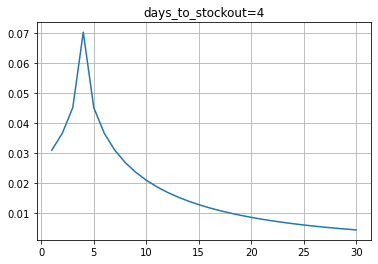

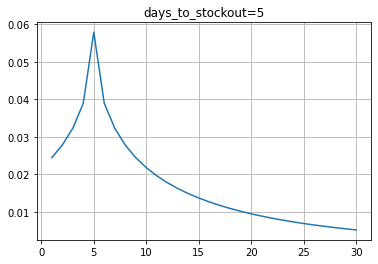

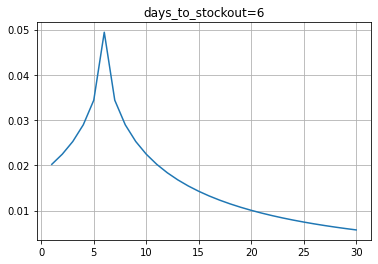

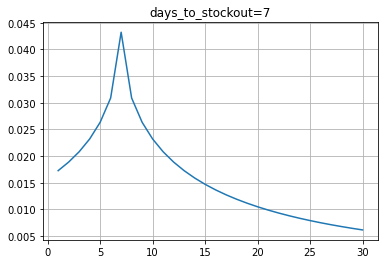

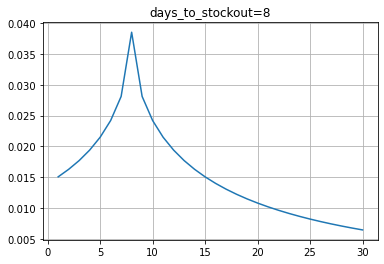

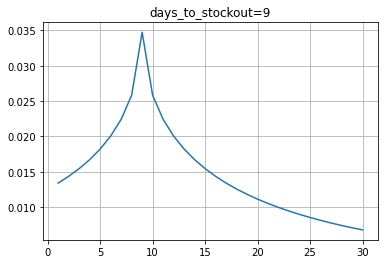

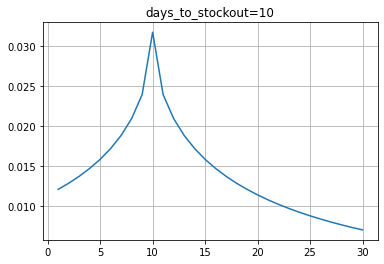

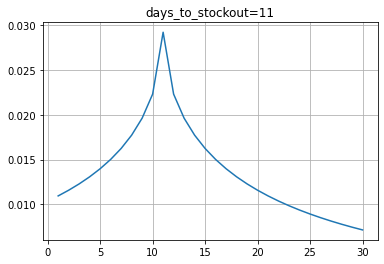

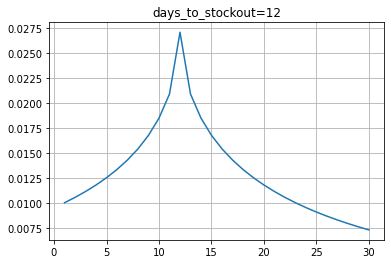

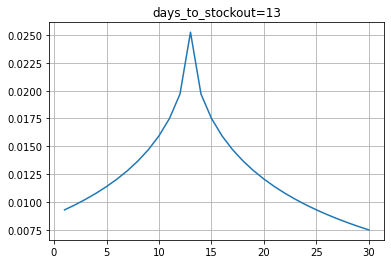

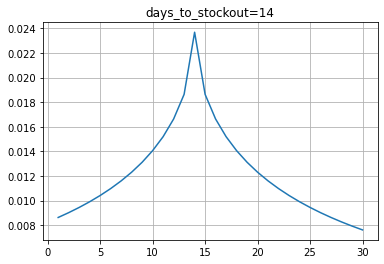

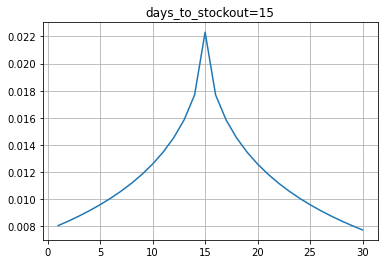

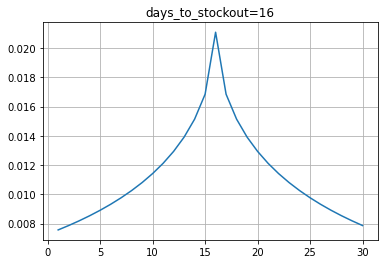

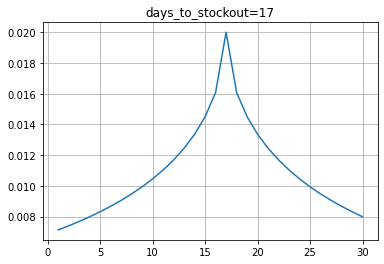

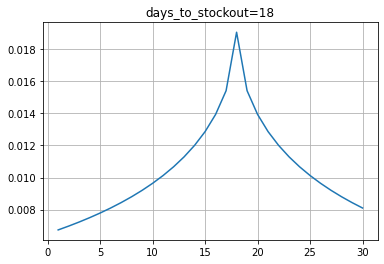

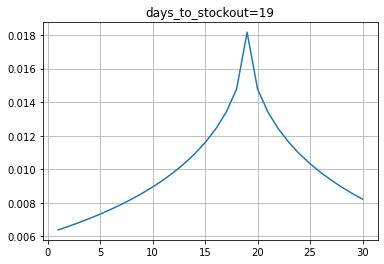

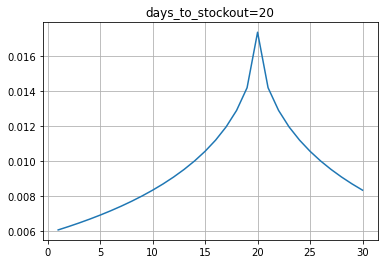

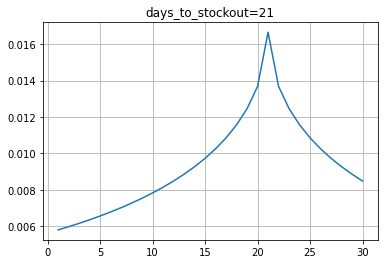

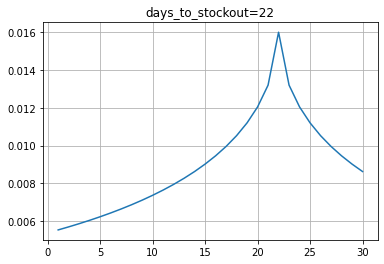

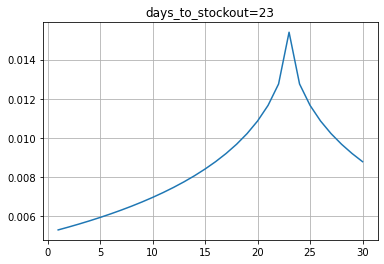

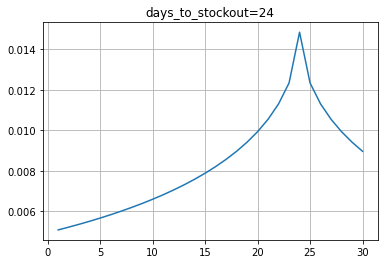

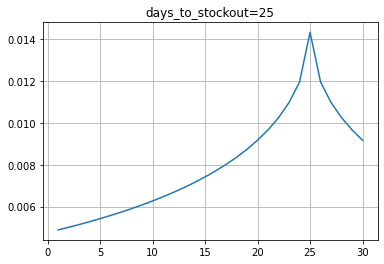

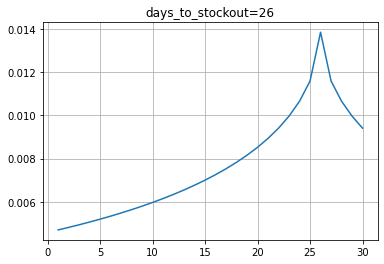

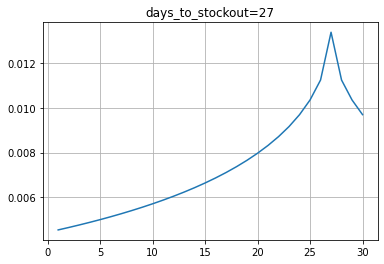

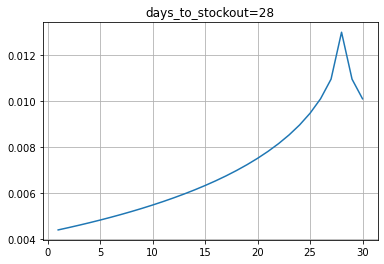

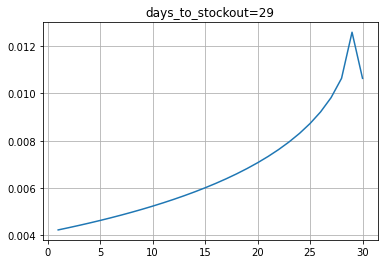

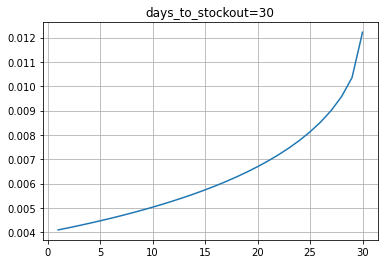

In [41]:
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (dist_config["lambda1"]*(days_to_stockout**dist_config["lambda2"]))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=dist_config["beta"])
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [42]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":dist_config["beta"]},
        lambda1=dist_config["lambda1"], 
        lambda2=dist_config["lambda2"],
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526189/526189 [02:53<00:00, 3039.20it/s]


In [43]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.059921,0.070171,0.087462,0.086402,0.069645,0.059562,0.052270,0.046590,0.041976,0.038124,0.034844,0.032010,0.029532,0.027346,0.025401,0.023660,0.022092,0.020674,0.019384,0.018208,0.017132,0.016143,0.015233,0.014393,0.013615,0.012894,0.012224,0.011600,0.011018,0.010475
1,0.020742,0.021219,0.021714,0.022229,0.022765,0.023324,0.023907,0.024517,0.025155,0.025824,0.026526,0.027264,0.028042,0.028863,0.029732,0.030654,0.031636,0.032684,0.033809,0.035020,0.036332,0.037763,0.039337,0.041085,0.043053,0.045312,0.047977,0.051270,0.055749,0.066498
2,0.025011,0.025371,0.025743,0.026126,0.026521,0.026930,0.027353,0.027791,0.028245,0.028716,0.029205,0.029715,0.030247,0.030802,0.031384,0.031994,0.032636,0.033314,0.034032,0.034796,0.035613,0.036491,0.037442,0.038483,0.039635,0.040934,0.042436,0.044250,0.046649,0.052134
3,0.024634,0.025766,0.026998,0.028347,0.029835,0.031489,0.033348,0.035467,0.037925,0.040856,0.044505,0.049439,0.058140,0.052515,0.046522,0.042399,0.039184,0.036532,0.034272,0.032304,0.030562,0.029003,0.027594,0.026311,0.025135,0.024052,0.023051,0.022120,0.021253,0.020442
5,0.019765,0.020309,0.020879,0.021478,0.022107,0.022769,0.023468,0.024207,0.024989,0.025821,0.026707,0.027653,0.028669,0.029764,0.030949,0.032241,0.033658,0.035228,0.036988,0.038990,0.041321,0.044126,0.047712,0.053009,0.054814,0.048703,0.044857,0.041911,0.039488,0.037420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [45]:
test = pd.read_csv(f"{input_path}/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [46]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [47]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"{subs_path}/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***